In [1]:
"""Sunday lesson"""
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from pandas import DataFrame

from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

from keras.models import Sequential
from keras import layers

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

import pandas as pd

filepath_dict = {'yelp':   'data/datasets_2288_3869_yelp_labelled.txt',
                 'amazon': 'data/datasets_2288_3869_amazon_cells_labelled.txt',
                 'imdb':   'data/datasets_2288_3869_imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)

"""Test you dataset"""
for i in range(5):
    print(df.iloc[i])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object
sentence    Crust is not good.
label                        0
source                    yelp
Name: 1, dtype: object
sentence    Not tasty and the texture was just nasty.
label                                               0
source                                           yelp
Name: 2, dtype: object
sentence    Stopped by during the late May bank holiday of...
label                                                       1
source                                                   yelp
Name: 3, dtype: object
sentence    The selection on the menu was great and so wer...
label                                                       1
source                                                   yelp
Name: 4, dtype: object


In [2]:
from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.25, random_state=1000)

In [3]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

"""Probin indexing"""
index_sentence=4
print(sentences_train[index_sentence])
print(X_train[index_sentence])

In fact I'm going to round up to 4 stars, just because she was so awesome.
[14, 356, 83, 126, 5, 742, 59, 5, 357, 96, 41, 127, 234, 3, 25, 161]


In [4]:
for word in ['tasty', 'nasty','the', 'awesome', 'happy', 'sad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

tasty: 164
nasty: 691
the: 1
awesome: 161
happy: 320
sad: 450


In [5]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[index_sentence, :])

[ 14 356  83 126   5 742  59   5 357  96  41 127 234   3  25 161   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [6]:
"""Another way to work with embeddings is by using a MaxPooling1D/AveragePooling1D
or a GlobalMaxPooling1D/GlobalAveragePooling1D layer after the embedding."""
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           87350     
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           32128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 120,779
Trainable params: 120,779
Non-trainable params: 0
__________________________________________________

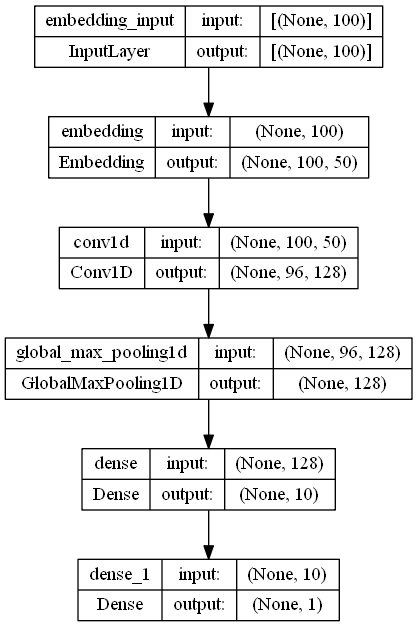

In [7]:
dot_img_file = 'Model2_TextClassifier.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [8]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

In [9]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                    callbacks=[es])

loss, accuracy = model.evaluate(X_train, y_train, verbose=2)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Epoch 1/50
75/75 [==============================] - 2s 12ms/step - loss: 0.6889 - accuracy: 0.5667 - val_loss: 0.6796 - val_accuracy: 0.6680
Epoch 2/50
75/75 [==============================] - 1s 9ms/step - loss: 0.5779 - accuracy: 0.8387 - val_loss: 0.5350 - val_accuracy: 0.7160
Epoch 3/50
75/75 [==============================] - 1s 11ms/step - loss: 0.2569 - accuracy: 0.9347 - val_loss: 0.4907 - val_accuracy: 0.7840
Epoch 4/50
75/75 [==============================] - 1s 13ms/step - loss: 0.0773 - accuracy: 0.9800 - val_loss: 0.4638 - val_accuracy: 0.8120
Epoch 5/50
75/75 [==============================] - 1s 10ms/step - loss: 0.0273 - accuracy: 0.9947 - val_loss: 0.5411 - val_accuracy: 0.8120
Epoch 6/50
75/75 [==============================] - 1s 9ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.5575 - val_accuracy: 0.7960
Epoch 7/50
75/75 [==============================] - 1s 10ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.5957 - val_accuracy: 0.8080
Epoch 8/50
75/7

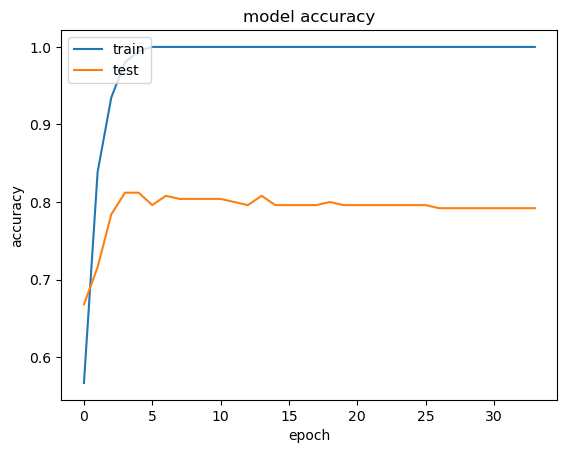

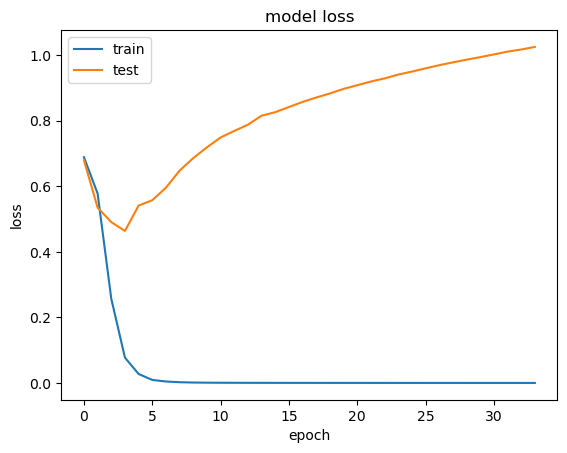

In [10]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()